# **5min stock data**

In this notebook we will explore a basic pipeline for 5min interval stock data. We will be working with a portfolio of highly correlated stocks: AAPL, GOOG, QCOM, and TSLA. We will train our models using the Balanced Focal Loss function and compare it to our previous performan using Categorical Cross Entropy Loss. These stocks were highly correlated around Aug - Oct 2022. The stock dataset contains timestamps, prices and trading volume, but does not contin any target variables.
- Timestamps &#8594; Interval
- Open/Close/High/Low Prices &#8594; Ratio
- Trading Volume &#8594; Ratio

To use the timestamps we will sinusoidally encode them. We will also add engineered features such as the price difference.

 We will create the target variable by taking the midpoint of Open/Close prices for M future days and then averaging these values. This target variable is Oridnal and has 3 possible classes: 
- 0 - downward price movement
- 1 - no change
- 2 - upward price movement

The price movements are derived by a threshold that is defined using the IQR method to detect outliers. Currently we use a limit of 1, and every Q1 outlier is classified as "0 - downward price movement", every Q3 outlier is classified as "2 - upward price movement", and all inliers are classified as: "1 - no change".

#### NOTE:
This dataset has discontinuities after each trading day (i.e. from final afterhours trade until the first afterhours trade the next day). It is possible that other afterhours activities could have occured to impact the prices during this time period. 

## Models

The main model we will be testing in this notebook is a Transformer Encoder. Typically a Transformer has an Encoder and Decoder portion, where the Encoder learns information about which parts of the input sequence are relevant to eachother. The Decoder does the opposite, it takes the continuouss representation learned by the Encoder and learns to generate an ordered output sequence. For the Time Series Classifiecation problem it is unecessary to include the Decoder, we can simply use the Encoder to learn relative correlations of the inputs and add a Vanilla Feed Forward Neural Network to the end of the Encoder Blocks to obtain the desired classification. [Source](https://userweb.cs.txstate.edu/~amk181/AIME_LSTM_Attention_vs_Transformer.pdf).

The Transformer Encoder also relies on positional encoding in order to implement this, we will first project the input vectors into high dimensional space as done [here](https://arxiv.org/pdf/2010.02803.pdf), and then add the positional Encoding as done in the [original paper](https://arxiv.org/pdf/1706.03762.pdf).


In order to compare how effective the Transformer is in modeling seuqential data, we will compare its results to:
- Baseline Model (uses previous predictions)
- Linear Model
- Neural Network
- LSTM

### Library Import

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [4]:
from data_utils import *
from data_pipeline import *
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

### Ensure that GPU is available

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data
Place all stocks in a Dictionary of DataFrames

In [ ]:
from glob import glob
import re

# get all data .csvs
data_paths = glob(os.path.join(BASE_DIR, r'data\raw\5min\*.csv'))

# get stock DataFrames dict
stock_dfs = get_stocks(data_paths, tgt_window=1, iqr_lim=0.1)

### Plot the of number of each class for each stock

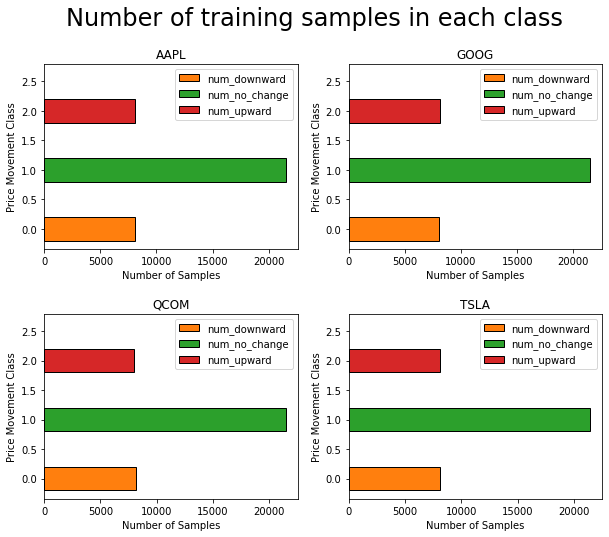

In [7]:
fig = plt.figure(figsize=(10, 8))

for i, name in enumerate(stock_dfs.keys()):
    # get plotting axes
    ax = plt.subplot(2, 2, i + 1)

    # get stock DataFrame
    df = stock_dfs[name]

    # compute class counts
    down = np.sum(df.price_change == 0)
    none = np.sum(df.price_change == 1)
    up = np.sum(df.price_change == 2)

    ax.barh([2.25], [0]) # expand to fit the legend
    ax.barh([0], [down], height=0.4, edgecolor='k', label='num_downward')
    ax.barh([1], [none], height=0.4, edgecolor='k', label='num_no_change')
    ax.barh([2], [up], height=0.4, edgecolor='k', label='num_upward')
    ax.set_title(name)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Price Movement Class')
    ax.legend();

# set main title
fig.suptitle('Number of training samples in each class', size=24)

# add a bit of space
fig.subplots_adjust(hspace=0.35);


### Display a table of values for each stock

In [8]:
stock_dfs['GOOG']

,Open,High,Low,Close,Volume,price_trend,price_change
2020-11-09 09:45:00,89.60550,89.608815,88.62005,89.111500,915140.0,-0.126500,0
2020-11-09 09:50:00,89.16850,89.678500,89.10300,89.295500,839000.0,-0.062222,1
2020-11-09 09:55:00,89.27625,89.363000,88.82850,89.063305,756060.0,0.038222,1
2020-11-09 10:00:00,89.00550,89.500000,88.90100,89.410500,413260.0,0.599000,2
2020-11-09 10:05:00,89.52500,90.089500,89.49000,90.089000,1021300.0,0.188250,2
...,...,...,...,...,...,...,...
2022-10-28 15:35:00,96.84500,96.860000,96.73500,96.850000,411646.0,-0.030000,1
2022-10-28 15:40:00,96.85500,96.855600,96.64000,96.780000,399264.0,-0.100000,0
2022-10-28 15:45:00,96.77000,96.770000,96.64000,96.665000,348569.0,-0.070500,1
2022-10-28 15:50:00,96.66900,96.740000,96.61500,96.625000,414491.0,0.033000,1


In [9]:
stock_dfs['GOOG'].iloc[:, :4].describe()

,Open,High,Low,Close
count,37661.000000,37661.000000,37661.000000,37661.000000
mean,120.390972,120.507638,120.268903,120.388429
std,18.364977,18.365407,18.363138,18.363302
min,85.095500,85.152000,84.950000,85.061250
25%,105.080000,105.208500,104.949910,105.072500
50%,119.135495,119.257500,118.990500,119.139900
75%,137.208215,137.345000,137.090500,137.200000
max,151.686500,152.029500,151.492500,151.694500


### Plot stocks prices

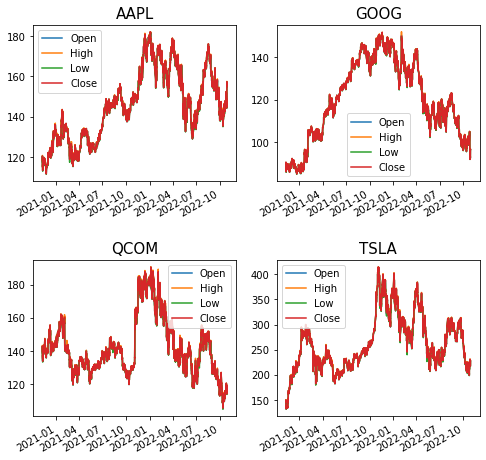

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

stock_dfs['AAPL'].iloc[:, :4].plot(ax=ax[0, 0])
stock_dfs['GOOG'].iloc[:, :4].plot(ax=ax[0, 1])
stock_dfs['QCOM'].iloc[:, :4].plot(ax=ax[1, 0])
stock_dfs['TSLA'].iloc[:, :4].plot(ax=ax[1, 1])


# set main title
# fig.suptitle('5min Stock Prices', size=18)

# set titles and axis labels
ax[0, 0].set_title('AAPL', size=15)
ax[0, 1].set_title('GOOG', size=15)
ax[1, 0].set_title('QCOM', size=15)
ax[1, 1].set_title('TSLA', size=15)

# add a bit of space
fig.subplots_adjust(hspace=0.5);
    

### Get train, valid, test splits for each stock

In [49]:
stock_dfs['AAPL']

,Open,High,Low,Close,Volume,price_trend,price_change
2020-11-09 09:45:00,117.873186,118.199814,117.269419,118.160223,3294925.0,0.583922,2
2020-11-09 09:50:00,118.160223,119.328166,118.001858,119.041030,3523902.0,0.131196,2
2020-11-09 09:55:00,119.036180,119.348061,118.011756,118.427464,3071728.0,-0.258284,0
2020-11-09 10:00:00,118.427365,118.664913,117.769259,118.519712,2231313.0,0.607232,2
2020-11-09 10:05:00,118.506647,119.743875,118.447260,119.654893,2935978.0,0.444858,2
...,...,...,...,...,...,...,...
2022-10-28 15:35:00,155.725000,155.930000,155.610000,155.920000,1418062.0,0.032500,1
2022-10-28 15:40:00,155.925000,155.925000,155.620000,155.785000,1303668.0,-0.066250,1
2022-10-28 15:45:00,155.780000,155.980000,155.740000,155.797500,1268977.0,-0.053750,1
2022-10-28 15:50:00,155.790000,155.910000,155.580000,155.680000,1691558.0,0.170000,2


In [12]:
split_dfs = get_split_dfs(stock_dfs, train_loc='2022-09-01', 
                          valid_loc_1='2022-09-02', valid_loc_2='2022-10-29', 
                          test_loc='2022-09-10')

### Get Data Generators
- One for baseline model
- One for simple non-sequential models (this will use window normalization)
- One for sequential models (This will use window normalization)

First we need to make a Data Generator that that can account for the time spans that we are interested in. We might be able to use specific timestamps to define the windows, i.e. 09:30-13:30

We should strive for a general method of doing this

### Get Data Generators
We will add data generators for each stock to dictionaries

In [13]:
base_gens = {}
single_gens = {}
window_gens = {}
    
for name in stock_dfs.keys():
    base_gen = WindowGenerator(
                input_width=1, label_width=1, shift=0,
                sample_weights=False,
                dfs=split_dfs[name],
                batch_size=32, 
                label_columns=['price_change'])

    single_gen = WindowGenerator(
                input_width=1, label_width=1, shift=0, 
                sample_weights=False,
                window_norm=False,
                dfs=split_dfs[name],
                remove_columns=['price_change', 'price_trend', 'dayofweek'],
                batch_size=32, 
                remove_nonsequential=False,
                label_columns=['price_change'])

    window_normed_gen = WindowGenerator(
                input_width=32, label_width=1, shift=0, 
                sample_weights=False,
                window_norm=True,
                dfs=split_dfs[name],
                remove_columns=['price_change', 'price_trend', 'dayofweek'],
                batch_size=32, 
                remove_nonsequential=False, # keep only simultaneous batch windows
                label_columns=['price_change'])

    # add to data generators
    base_gens.update({name : base_gen})
    single_gens.update({name : single_gen})
    window_gens.update({name : window_normed_gen})
        

In [14]:
for inputs, labels in window_gens['AAPL'].train.take(5):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 32, 5)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 5)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 5)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 5)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 5)
Labels shape (batch, time, features): (32, 1, 1)


### Start Training Models

In order to use Mathews Correlation Coefficient with predicted class probabilities, we will override thhe update_state function

In [15]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [16]:
train_performance = {}
val_performance = {}

In [17]:
for name in base_gens.keys():
    baseline = Baseline(label_index=base_gen.column_indices['price_change'])

    baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=[mcc_metric, 'accuracy'],
                    # weighted_metrics=['accuracy'],
                    )

    train_performance[f'Baseline_{name}'] = baseline.evaluate(base_gens[name].train)
    val_performance[f'Baseline_{name}'] = baseline.evaluate(base_gens[name].valid)

95/95 [==============================] - 0s 3ms/step - loss: nan - mcc_metric: 0.0000e+00 - accuracy: 0.2152


In [18]:
from sklearn.metrics import accuracy_score, matthews_corrcoef


for name in split_dfs.keys():

    train_df = split_dfs[name][0]
    valid_df = split_dfs[name][1]

    base_train_acc = accuracy_score(train_df.price_change.iloc[1:],  # targets
                                    train_df.price_change.iloc[:-1]) # baseline predictions

    base_train_mcc = matthews_corrcoef(train_df.price_change.iloc[1:],  # targets
                                       train_df.price_change.iloc[:-1]) # baseline predictions

    base_valid_acc = accuracy_score(valid_df.price_change.iloc[1:],  # targets
                                    valid_df.price_change.iloc[:-1]) # baseline predictions

    base_valid_mcc = matthews_corrcoef(valid_df.price_change.iloc[1:],  # targets
                                       valid_df.price_change.iloc[:-1]) # baseline predictions

    train_performance[f'Baseline_{name}'] = [base_train_acc, base_train_mcc]
    val_performance[f'Baseline_{name}'] = [base_valid_acc, base_valid_mcc]

In [26]:
train_performance

{'Baseline_AAPL': [0.5940911453820829, 0.2926383209477514],
 'Baseline_GOOG': [0.5681522775194247, 0.25594683105159255],
 'Baseline_QCOM': [0.6002425922717033, 0.3108823414550118],
 'Baseline_TSLA': [0.5966037081961532, 0.30786702363544344],
 'linear_AAPL': [1.9193814992904663, 0.5671296715736389, 0.14509107172489166],
 'linear_GOOG': [1.8371683359146118, 0.35387903451919556, 0.07612337917089462],
 'linear_QCOM': [1.053459882736206, 0.578277051448822, 0.2814244329929352],
 'linear_TSLA': [1.8311132192611694, 0.49386316537857056, 0.1797492802143097]}

In [27]:
val_performance

{'Baseline_AAPL': [0.5072416063199473, 0.23846036599322837],
 'Baseline_GOOG': [0.543449637919684, 0.2403414411299258],
 'Baseline_QCOM': [0.5447662936142199, 0.24880595694632565],
 'Baseline_TSLA': [0.5516787360105333, 0.2414679845859339],
 'linear_AAPL': [1.3604209423065186, 0.5330700874328613, 0.2193784862756729],
 'linear_GOOG': [1.1412543058395386, 0.5199078917503357, 0.16863787174224854],
 'linear_QCOM': [1.3587056398391724, 0.3195129930973053, 0.1843000054359436],
 'linear_TSLA': [1.4199621677398682, 0.4442250728607178, 0.20675602555274963]}

Add a function to streamline the rest of the training process. First we will compute normalized class weights to help with the class imbalance.

In [19]:
def get_class_weights(dfs, name):
    class_counts = np.bincount(dfs[name][0].price_change)
    total = class_counts.sum()
    n_classes = len(class_counts)

    weights = []
    for idx, count in enumerate(class_counts):
        # compute balanced weights
        weights.append(total / (n_classes*count))

        # get inverse frequency class weighting
        # weights.append(1/np.power(count, 1))


    weights = np.array(weights) 
    # weights = weights / weights.sum()
    return weights

In [51]:
get_class_weights(split_dfs, 'AAPL')

array([1.59490581, 0.57265   , 1.59556723])

In [52]:
from focal_loss import SparseCategoricalFocalLoss

def compile_and_fit(model, window, lr=1e-4, max_epochs=100, lr_scheduler=None, patience=5, weights=None):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    
    model.compile(
        loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights),
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), mcc_metric],
        # weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

    if lr_scheduler:
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        history = model.fit(window.train, epochs=max_epochs,
                            validation_data=window.valid,
                            callbacks=[lr_callback, early_stopping])
    else:
        history = model.fit(window.train, epochs=max_epochs,
                            validation_data=window.valid,
                            callbacks=[early_stopping])
    return history

### Train the Linear model
Entire dataset is standardized here

In [53]:
linear_models = {}

for name in single_gens.keys():

    linear = tf.keras.Sequential([
        layers.Dense(units=3, activation='softmax')
    ])

    weights = get_class_weights(split_dfs, name)
    history = compile_and_fit(linear, single_gens[name], lr=0.35, max_epochs=30, weights=weights)

    linear_models.update({name : linear})
    train_performance[f'linear_{name}'] = linear.evaluate(single_gens[name].train, verbose=False)
    val_performance[f'linear_{name}'] = linear.evaluate(single_gens[name].valid, verbose=False)

Epoch 1/30
1083/1083 [==============================] - 9s 7ms/step - loss: 0.7060 - sparse_categorical_accuracy: 0.4497 - mcc_metric: 0.0702 - val_loss: 1.4024 - val_sparse_categorical_accuracy: 0.3771 - val_mcc_metric: 0.0454
Epoch 2/30
1083/1083 [==============================] - 7s 7ms/step - loss: 0.6889 - sparse_categorical_accuracy: 0.4652 - mcc_metric: 0.0886 - val_loss: 1.1990 - val_sparse_categorical_accuracy: 0.3715 - val_mcc_metric: 0.0558
Epoch 3/30
1083/1083 [==============================] - 7s 7ms/step - loss: 0.6701 - sparse_categorical_accuracy: 0.4753 - mcc_metric: 0.1067 - val_loss: 1.1880 - val_sparse_categorical_accuracy: 0.3705 - val_mcc_metric: 0.0717
Epoch 4/30
1083/1083 [==============================] - 7s 7ms/step - loss: 0.6568 - sparse_categorical_accuracy: 0.4810 - mcc_metric: 0.1179 - val_loss: 1.1665 - val_sparse_categorical_accuracy: 0.3676 - val_mcc_metric: 0.0736
Epoch 5/30
1083/1083 [==============================] - 7s 7ms/step - loss: 0.6379 - spa

In [54]:
def get_label_preds(model, data_gen, threshold=0):
    ''' Obtains truth labels and predictions for a model/data_gen pair '''
    # get predictions
    prediction_vectors = model.predict(data_gen, verbose=False)
    predictions = tf.argmax(prediction_vectors, axis=-1)

    # get labels
    # labels = tf.concat([_labels for _, _labels, _ in data_gen], axis=0)
    labels = tf.concat([_labels for _, _labels in data_gen], axis=0)
    labels = tf.squeeze(labels, axis=-1)

    if threshold > 0:
        probs = tf.reduce_max(prediction_vectors, axis=-1)
        locs = probs > threshold

        predictions = predictions[locs]
        labels = labels[locs]

    return predictions, labels

In [55]:
for name in split_dfs.keys():

    train_preds, train_labels = get_label_preds(linear_models[name], 
                                                single_gens[name].train, 
                                                threshold=0)
    valid_preds, valid_labels = get_label_preds(linear_models[name], 
                                                single_gens[name].valid, 
                                                threshold=0)

    train_acc = accuracy_score(train_labels, # targets
                               train_preds)  # predictions

    train_mcc = matthews_corrcoef(train_labels, # targets
                                  train_preds)  #  predictions

    valid_acc = accuracy_score(valid_labels, # targets
                               valid_preds)  # predictions

    valid_mcc = matthews_corrcoef(valid_labels, # targets
                                  valid_preds)  #  predictions


    print(name, ' train acc: ', train_acc, ' mcc: ', train_mcc)
    print(name, ' valid acc: ', valid_acc, ' mcc: ', valid_mcc)

AAPL  train acc:  0.5768331071129466  mcc:  0.24927569320518214
AAPL  valid acc:  0.5195788088186903  mcc:  0.24896701111624847
GOOG  train acc:  0.26101900525677313  mcc:  0.034548345609092444
GOOG  valid acc:  0.2836459361632116  mcc:  0.06150884281563827
QCOM  train acc:  0.44234268056718745  mcc:  0.21163465556620528
QCOM  valid acc:  0.29417571569595263  mcc:  0.1949885775190076
TSLA  train acc:  0.4767955641551391  mcc:  0.21165043707256817
TSLA  valid acc:  0.3984863441921685  mcc:  0.10091391065908971


### Train the transformer Model

Use learning rate schuler to warmpup Transformer learning rate

In [56]:
def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [64]:
transformer_models = {}

for name in single_gens.keys():

    transformer_model = TransformerModel(
                                    n_heads=2,
                                    d_model=256,
                                    ff_dim=256,
                                    num_transformer_blocks=1,
                                    mlp_units=[256],
                                    n_outputs=3,
                                    dropout=0.3,
                                    mlp_dropout=0.3)

    weights = get_class_weights(split_dfs, name)
    history = compile_and_fit(transformer_model, window_gens[name], lr=1e-6, max_epochs=30, 
                          lr_scheduler=lr_scheduler, patience=5, weights=weights)

    transformer_models.update({name : transformer_model})
    train_performance[f'transformer_{name}'] = transformer_model.evaluate(window_gens[name].train, verbose=False)
    val_performance[f'transformer_{name}'] = transformer_model.evaluate(window_gens[name].valid, verbose=False)


Epoch 1/30
1082/1082 [==============================] - 17s 15ms/step - loss: 0.6401 - sparse_categorical_accuracy: 0.4153 - mcc_metric: 0.0069 - val_loss: 0.5421 - val_sparse_categorical_accuracy: 0.3082 - val_mcc_metric: 0.0405 - lr: 1.0000e-06
Epoch 2/30
1082/1082 [==============================] - 15s 14ms/step - loss: 0.4891 - sparse_categorical_accuracy: 0.4332 - mcc_metric: 0.0166 - val_loss: 0.5383 - val_sparse_categorical_accuracy: 0.2912 - val_mcc_metric: 0.0343 - lr: 6.7600e-05
Epoch 3/30
1082/1082 [==============================] - 15s 14ms/step - loss: 0.4770 - sparse_categorical_accuracy: 0.4487 - mcc_metric: 0.0277 - val_loss: 0.5376 - val_sparse_categorical_accuracy: 0.2952 - val_mcc_metric: 0.0358 - lr: 1.3420e-04
Epoch 4/30
1082/1082 [==============================] - 15s 14ms/step - loss: 0.4708 - sparse_categorical_accuracy: 0.4579 - mcc_metric: 0.0596 - val_loss: 0.4999 - val_sparse_categorical_accuracy: 0.3753 - val_mcc_metric: 0.1943 - lr: 2.0080e-04
Epoch 5/30
1

In [65]:
from sklearn.metrics import accuracy_score, matthews_corrcoef


for name in split_dfs.keys():

    train_preds, train_labels = get_label_preds(transformer_models[name], 
                                                window_gens[name].train, 
                                                threshold=0)
    valid_preds, valid_labels = get_label_preds(transformer_models[name], 
                                                window_gens[name].valid, 
                                                threshold=0)

    train_acc = accuracy_score(train_labels, # targets
                               train_preds)  # predictions

    train_mcc = matthews_corrcoef(train_labels, # targets
                                  train_preds)  #  predictions

    valid_acc = accuracy_score(valid_labels, # targets
                               valid_preds)  # predictions

    valid_mcc = matthews_corrcoef(valid_labels, # targets
                                  valid_preds)  #  predictions


    print(name, ' train acc: ', train_acc, ' mcc: ', train_mcc)
    print(name, ' valid acc: ', valid_acc, ' mcc: ', valid_mcc)

AAPL  train acc:  0.43334489536362586  mcc:  0.25934721884088024
AAPL  valid acc:  0.504654255319149  mcc:  0.31371166528970773
GOOG  train acc:  0.4168425312942673  mcc:  0.24819154831932722
GOOG  valid acc:  0.4654255319148936  mcc:  0.3075134459392061
QCOM  train acc:  0.49528847265579834  mcc:  0.09200564928521722
QCOM  valid acc:  0.4953457446808511  mcc:  0.10467496797794838
TSLA  train acc:  0.5306971904266389  mcc:  0.3112471424692882
TSLA  valid acc:  0.5518617021276596  mcc:  0.34504145859751084


### Train the LSTM

In [66]:
lstm_models = {}

for name in single_gens.keys():

    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        layers.LSTM(25, dropout=0.0),
        # Shape => [batch, time, features]
        layers.Dense(units=3, activation='softmax'),
        layers.Reshape([1, -1])
    ])

    weights = get_class_weights(split_dfs, name)
    history = compile_and_fit(lstm_model, window_gens[name], lr=0.01, max_epochs=30, 
                              patience=5, weights=weights)

    lstm_models.update({name : lstm_model})
    train_performance[f'lstm_{name}'] = lstm_model.evaluate(window_gens[name].train, verbose=False)
    val_performance[f'lstm_{name}'] = lstm_model.evaluate(window_gens[name].valid, verbose=False)


Epoch 1/30
1082/1082 [==============================] - 12s 10ms/step - loss: 0.3620 - sparse_categorical_accuracy: 0.5576 - mcc_metric: 0.2874 - val_loss: 0.3958 - val_sparse_categorical_accuracy: 0.5489 - val_mcc_metric: 0.3452
Epoch 2/30
1082/1082 [==============================] - 11s 10ms/step - loss: 0.3338 - sparse_categorical_accuracy: 0.5680 - mcc_metric: 0.3181 - val_loss: 0.3919 - val_sparse_categorical_accuracy: 0.5552 - val_mcc_metric: 0.3490
Epoch 3/30
1082/1082 [==============================] - 11s 10ms/step - loss: 0.3276 - sparse_categorical_accuracy: 0.5739 - mcc_metric: 0.3285 - val_loss: 0.3893 - val_sparse_categorical_accuracy: 0.5572 - val_mcc_metric: 0.3479
Epoch 4/30
1082/1082 [==============================] - 11s 10ms/step - loss: 0.3239 - sparse_categorical_accuracy: 0.5789 - mcc_metric: 0.3338 - val_loss: 0.3871 - val_sparse_categorical_accuracy: 0.5595 - val_mcc_metric: 0.3487
Epoch 5/30
1082/1082 [==============================] - 11s 10ms/step - loss: 0.

In [68]:
for name in split_dfs.keys():

    train_preds, train_labels = get_label_preds(lstm_models[name], 
                                                window_gens[name].train, 
                                                threshold=0)
    valid_preds, valid_labels = get_label_preds(lstm_models[name], 
                                                window_gens[name].valid, 
                                                threshold=0)

    train_acc = accuracy_score(train_labels, # targets
                               train_preds)  # predictions

    train_mcc = matthews_corrcoef(train_labels, # targets
                                  train_preds)  #  predictions

    valid_acc = accuracy_score(valid_labels, # targets
                               valid_preds)  # predictions

    valid_mcc = matthews_corrcoef(valid_labels, # targets
                                  valid_preds)  #  predictions


    print(name, ' train acc: ', np.round(train_acc, 4), ' mcc: ', np.round(train_mcc, 4))
    print(name, ' valid acc: ', np.round(valid_acc, 4), ' mcc: ', np.round(valid_mcc, 4))

AAPL  train acc:  0.5243  mcc:  0.3372
AAPL  valid acc:  0.5685  mcc:  0.3662
GOOG  train acc:  0.5389  mcc:  0.3037
GOOG  valid acc:  0.5568  mcc:  0.345
QCOM  train acc:  0.5469  mcc:  0.3341
QCOM  valid acc:  0.5625  mcc:  0.354
TSLA  train acc:  0.597  mcc:  0.362
TSLA  valid acc:  0.5987  mcc:  0.3654


### Get Classification Performance

Function to get the predictions and labels

In [115]:
def get_label_preds(model, data_gen, threshold=0):
    ''' Obtains truth labels and predictions for a model/data_gen pair '''
    # get predictions
    prediction_vectors = model.predict(data_gen)
    predictions = tf.argmax(prediction_vectors, axis=-1)

    # get labels
    # labels = tf.concat([_labels for _, _labels, _ in data_gen], axis=0)
    labels = tf.concat([_labels for _, _labels in data_gen], axis=0)
    labels = tf.squeeze(labels, axis=-1)

    if threshold > 0:
        probs = tf.reduce_max(prediction_vectors, axis=-1)
        locs = probs > threshold

        predictions = predictions[locs]
        labels = labels[locs]

    return predictions, labels

In [116]:
base_train_preds, base_train_labels = get_label_preds(baseline, base_gen.train)
base_valid_preds, base_valid_labels = get_label_preds(baseline, base_gen.valid)

400/400 [==============================] - 0s 912us/step


In [118]:
linear_train_preds, linear_train_labels = get_label_preds(linear, 
                                                          single_gens['AAPL'].train,
                                                          threshold=0.)
linear_valid_preds, linear_valid_labels = get_label_preds(linear, 
                                                          single_gens['AAPL'].valid,
                                                          threshold=0.)

407/407 [==============================] - 1s 1ms/step


In [119]:
tf.math.confusion_matrix(tf.squeeze(linear_train_labels), linear_train_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 4817,  2797,  4374],
       [ 9458, 21368, 14613],
       [ 3955,  2719,  5392]])>

In [120]:
tf.math.confusion_matrix(tf.squeeze(linear_valid_labels), linear_valid_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 824,  736, 1345],
       [1178, 3445, 2599],
       [ 433,  745, 1710]])>

In [121]:
xformer_train_preds, xformer_train_labels = get_label_preds(transformer_model, 
                                                            window_gens['AAPL'].train,
                                                            threshold=0.)
xformer_valid_preds, xformer_valid_labels = get_label_preds(transformer_model, 
                                                            window_gens['AAPL'].valid,
                                                            threshold=0.)

406/406 [==============================] - 2s 4ms/step


In [ ]:
tf.math.confusion_matrix(tf.squeeze(xformer_train_labels), xformer_train_preds)

In [ ]:
tf.math.confusion_matrix(tf.squeeze(xformer_valid_labels), xformer_valid_preds)

In [ ]:
lstm_train_preds, lstm_train_labels = get_label_preds(lstm_model, 
                                                      window_gens['AAPL'].train,
                                                      threshold=0.)
lstm_valid_preds, lstm_valid_labels = get_label_preds(lstm_model, 
                                                      window_gens['AAPL'].valid,
                                                      threshold=0.)